In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.data_generation import generate_data
from hydra import compose, initialize
from omegaconf import OmegaConf

# load config using hydra
with initialize(version_base=None, config_path="config", job_name="test_app"):
    cfg = compose(config_name="config")

torch.set_num_threads(1)

In [2]:
cfg.data.N = 50
cfg.graph.graph_type = 'RANDOM'

In [3]:
device = torch.device('cpu')

# generate data and move to device
X, y, graph_filters_flat, weight_matrix, filter_coefficients = [d.to(device) for d in generate_data(cfg)]

In [ ]:
y_in = y[:, :, 0].cpu().numpy()

hyperparams = {"P": 3,
               "gamma": 1.75,
               "lambda": 0.99,
                "nu": 0.005,
                "w_stepsize": 0.01,
                "h_stepsize": 0.001,
                "psi_stepsize": 1e-5,
                "epsilon": 1e-3,
                "ma_alpha": 0.005,
                "use_path_1": True,
                "instant_h": True,
                "patience": 250,
                "burn_in_debiasing": 250,
                "min_delta_percent": 0.01,
                "use_armijo": False,
                "warm_up_steps": 0,
                "alternate": False,
                "alternate_mod": 2,
                "monitor_debiasing": "pred_error_recursive_moving_average_h",
                "mus": [0.1, 0.1, 0.1]
               }
device = 'cpu'
from src.models.adaptive.AdaCGP_numpy import AdaCGP
model = AdaCGP(cfg.data.N, hyperparams, device)
model_inputs = {
    'X': X.cpu().numpy(),
    'y': y.cpu().numpy(),
    'weight_matrix': weight_matrix.cpu().numpy(),
    'filter_coefficients': filter_coefficients.cpu().numpy(),
    'graph_filters_flat': graph_filters_flat.cpu().numpy(),
}
results_np = model.run(**model_inputs)

print('\n')
from src.models.adaptive.AdaCGP import AdaCGP
model = AdaCGP(cfg.data.N, hyperparams, device)
model_inputs = {
    'X': X.to(device),
    'y': y.to(device),
    'weight_matrix': weight_matrix.to(device),
    'filter_coefficients': filter_coefficients.to(device),
    'graph_filters_flat': graph_filters_flat.to(device),
}
results_torch = model.run(**model_inputs)

  0%|          | 0/10000 [00:00<?, ?it/s, MA y error=1, Step=0.00575, Converged=0]

 32%|███▏      | 3157/10000 [00:27<00:59, 115.47it/s, MA y error=0.801, Step=0.00131, Converged=1] 


  1%|          | 101/10000 [00:02<04:54, 33.66it/s, MA y error=0.966, Step=0.00146, Converged=0]

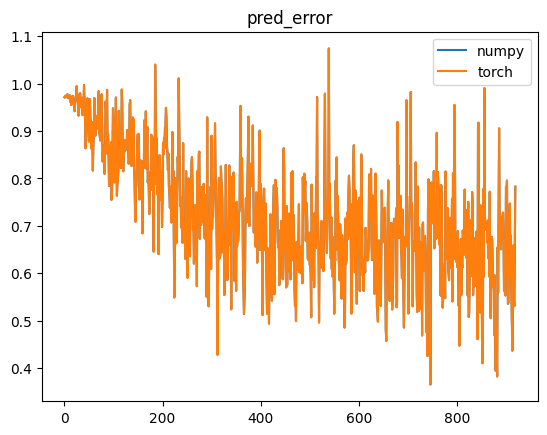

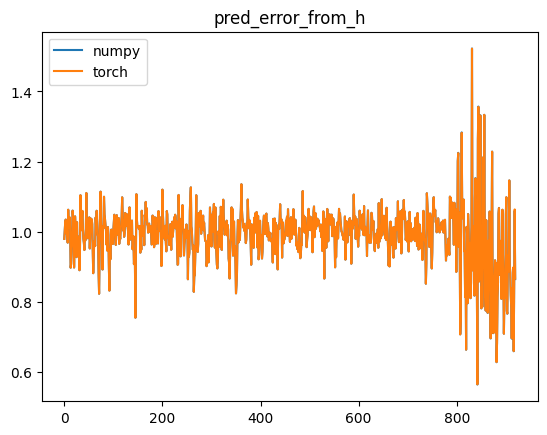

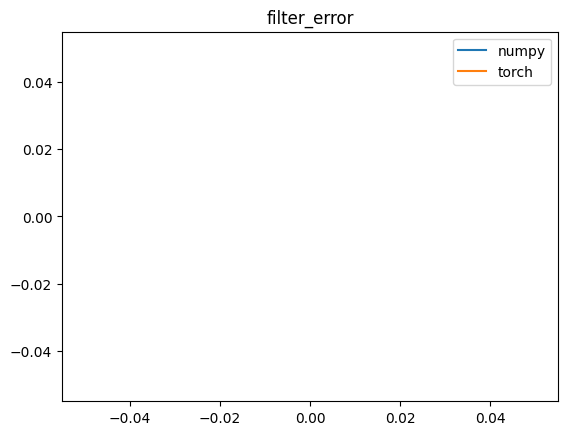

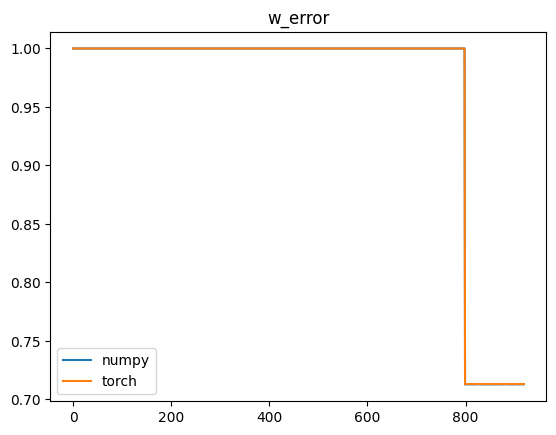

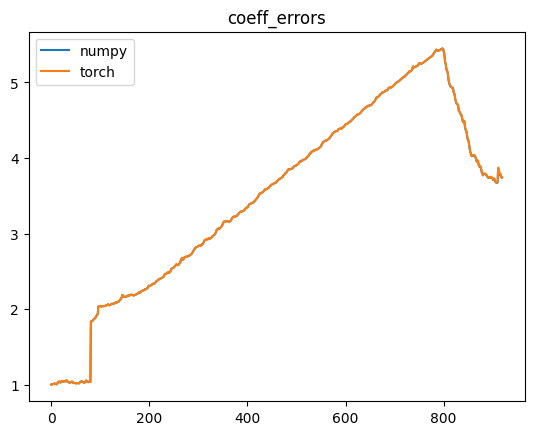

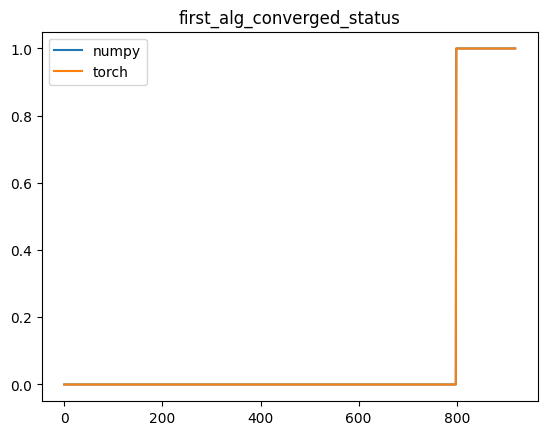

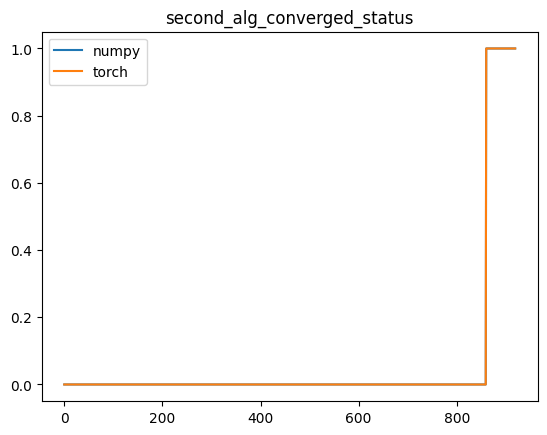

ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 50, 50)

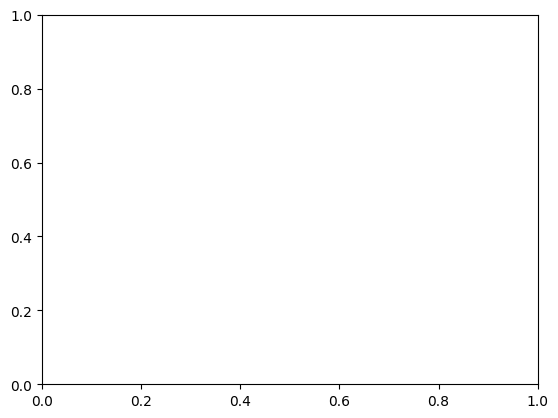

In [ ]:
# check each entry is the same in the results
for key in results_np:
    fig = plt.figure()
    plt.plot(results_np[key] - np.array(results_torch[key]))
    plt.title(key)
    plt.legend()
    plt.show()

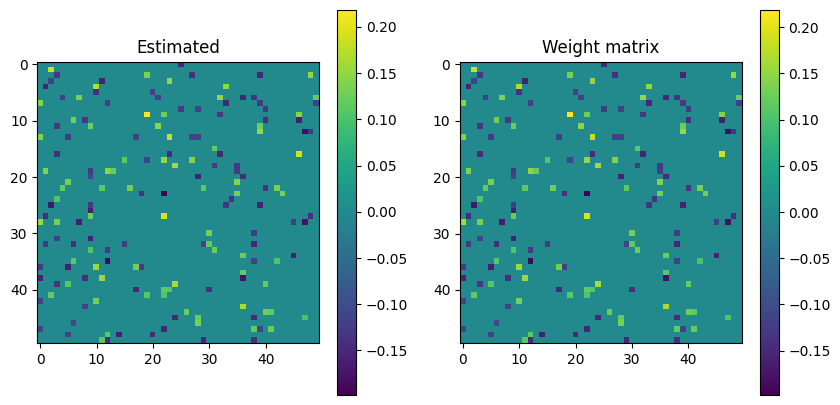

NameError: name 'results' is not defined

In [10]:
# plot the precision matrix and the weight matrix side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(results_np['matrices'][-1])
plt.title('Estimated')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(results_torch['matrices'][-1])
plt.title('Weight matrix')
plt.colorbar()
plt.show()

plt.plot(results['w_error'], label='w_error')
plt.plot(results['p_miss'], label='p_miss')
plt.plot(results['p_false_alarm'], label='p_false_alarm')
plt.legend()